## IUM 23Z - Etap I
#### Błażej Ejzak 313220, Paweł Dombrzalski 318647 

#### Zadanie:
„Nasi użytkownicy chcą słyszeć muzykę możliwie najszybciej po uruchomieniu 
odtwarzania utworu. Nie możemy jednak całej muzyki utrzymywać w naszym najszybszym 
cache’u – jest to zbyt drogie. Pracujemy nad rozwiązaniem, które każdego wieczora będzie 
rozmieszczało muzykę (na następne 24h) pomiędzy różnymi poziomami cache – tak, aby 
zminimalizować koszty. Pytanie: skąd mamy wiedzieć, gdzie dany utwór umieścić?”
#### Kontekst 
Serwis strumieniowy oferujący dostęp do muzyki.
#### Problem biznesowy
Rozmieszczenie utworów w różnych poziomach cache'u na następne 24 godziny w celu szybszego dostępu do muzyki dla użytkowników. Rozmieszczenie utworów będzie określane na podstawie wybranych atrybutów z dostępnych tabel danych co będzie wynikiem wyuczonego modelu.
#### Biznesowe kryteria sukcesu
Dopasowanie utworów do odpowiednich poziomów cache'u pod względem ich popularności. System powinien rozmieszczać utwory tak, aby dostęp do muzyki był szybszy oraz poniesione koszta mniejsze niż obecnie. 
#### Zadanie modelowania
Analiza szeregów czasowych - uwzględnienie dotychczasowej historii odtworzeń danych utworów oraz ich popularności w celu ustalenia rozmieszczenia muzyki do poszczególnych cache'y na następną dobę.
#### Analityczne kryteria sukcesu
Porównanie uzyskanych przez model wyników z kosztem obecnego rozmieszczenia utworów - nowy koszt powinien być nie większy niż obecny.  Koszt rozmieszczenia utworów będzie liczony na podstawie tabeli track_storage. Każdy poziom cache będzie miał nadaną wartość liczbową, o róznych rzędach wielkości - im szybszy cache, tym większa wartość. Ta liczba będzie przemnożona przez długość utworu - dostępna w tabeli tracks. Oprócz tego szybkość dostępu do muzyki powinna być nie większa niż obecnie. Możemy ją wyliczyć na podstawie tabeli sessions - biorąc timestamp ostatniego eventu play z sesji i odejmując timestamp pierwszego eventu w play sesji uzyskamy całkowity czas sesji. Po odjęciu od tego czasu czasów trwania poszczególnych utworów uzyskamy łączny czas ładowania utworów w sesji. Sumując te czasy dla wszystkich sesji uzyskamy łączny czas ładowania muzyki. Dążymy do tego aby średni czas oczekiwania wszystkich uczestników był jak najmniejszy - przy podobnych kosztach chcemy uzyskać poprawę o około 50%.

In [35]:
# imports
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

DATA_PATH1 = "./data_v1/sessions.jsonl"
DATA_PATH2 = "./data_v1/track_storage.jsonl"
DATA_PATH3 = "./data_v2/tracks.jsonl"

### Wstępne przejrzenie dostępnych danych

In [36]:
session_data = pd.DataFrame(pd.read_json(DATA_PATH1, lines=True))
session_data.head()

,session_id,timestamp,user_id,track_id,event_type
0,124,2022-11-25 17:43:32.000,121.0,31AOj9sFz2gM0O3hMARRBx,play
1,125,2022-11-25 17:44:28.427,121.0,2EEfUuBRZA4Ax1vYcluFS0,play
2,126,2022-11-25 12:44:26.000,125.0,0yB4jrSwN0bFtFRDR5vyMj,play
3,126,2022-11-25 12:47:51.306,125.0,2xxq5LXFBFyawPChsOOWVu,play
4,126,2022-11-25 12:51:29.253,125.0,0zRc5cHuMrulujN8t1XbYE,play


In [37]:
session_data.describe(include="all")

,session_id,timestamp,user_id,track_id,event_type
count,80279.000000,80279,76209.000000,65685,76190
unique,NaN,NaN,NaN,19095,4
top,NaN,NaN,NaN,0cITLOYn1Sv4q27zZPqlNK,play
freq,NaN,NaN,NaN,17,42043
mean,7242.837778,2023-05-23 14:24:27.216211456,125.642811,NaN,NaN
min,124.000000,2022-11-25 11:49:52,101.000000,NaN,NaN
25%,3682.000000,2023-02-21 08:21:27.016999936,113.000000,NaN,NaN
50%,7319.000000,2023-05-26 05:43:56.054000128,126.000000,NaN,NaN
75%,10759.000000,2023-08-15 16:22:02.784000,138.000000,NaN,NaN
max,14317.000000,2023-11-25 11:48:25.680000,150.000000,NaN,NaN


In [38]:
session_data.columns

Index(['session_id', 'timestamp', 'user_id', 'track_id', 'event_type'], dtype='object')

#### Procent wartości null w zbiorze session_data

In [39]:
column_nulls = session_data.isnull().sum() * 100 / len(session_data)
print(column_nulls)

session_id     0.000000
timestamp      0.000000
user_id        5.069819
track_id      18.179100
event_type     5.093486
dtype: float64


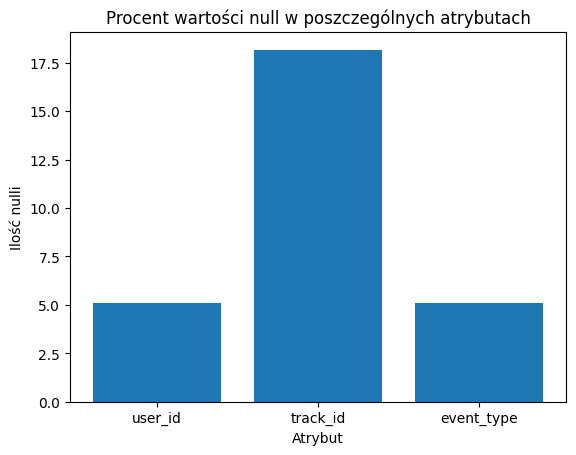

In [40]:
plt.title("Procent wartości null w poszczególnych atrybutach")
plt.xlabel("Atrybut")
plt.ylabel("Ilość nulli")
plt.bar(column_nulls[column_nulls > 0].index, column_nulls[column_nulls > 0].values, align='center')
plt.show()

#### Atrybuty w zbiorze sessions:
* session_id - id sesji, liczba całkowita, sekwencja
* timestamp - znacznik czasowy, w formacie YYYY-MM-DD HH:MM:SS.miliseconds
* user_id - id użytkownika, liczba całkowita, atrybut dyskretny nominalny
* track_id - string, id ścieżki dźwiękowej, atrybut dyskretny nominalny, duża ilość wartości
* event_type - string, id eventu, atrybut dyskretny nominalny - wartości [play, advertisment, like, skip]

#### Atrybut timestamp
Ilość nulli - 0%

Liczba zdarzeń w każdej godzinie:

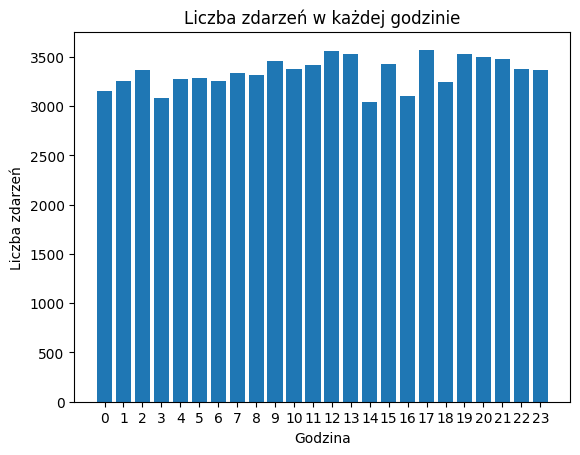

In [41]:
session_data["time"] = pd.to_datetime(session_data["timestamp"].dt.time.astype(str), format='mixed')
plt.title("Liczba zdarzeń w każdej godzinie")
plt.xlabel("Godzina")
plt.ylabel("Liczba zdarzeń")
plt.bar(session_data["time"].dt.hour.unique() ,session_data["time"].dt.hour.value_counts(), align='center')
plt.xticks(session_data["time"].dt.hour.unique())
plt.show()

Średnia liczba zdarzeń na godzinę:

In [42]:
session_data["time"].mean()

Timestamp('2023-12-29 11:53:15.533704192')

#### Atrybut user_id
Ilość nulli - ok. 5,07%


Rozkład:

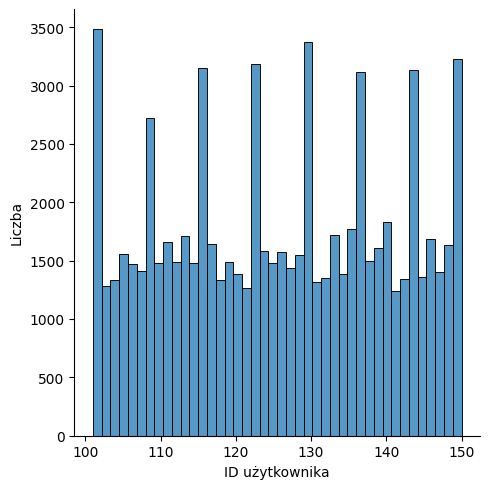

In [43]:
user_hist = sns.displot(session_data, x="user_id")
user_hist.set(xlabel="ID użytkownika", ylabel="Liczba")
plt.show()

#### Atrybut event_type
Ilość nulli - ok. 5,09%


Rozkład:

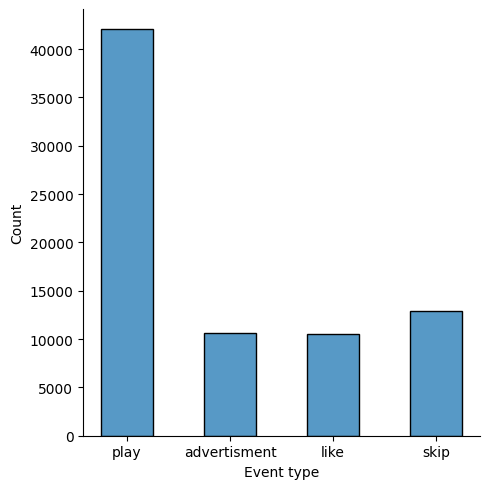

In [44]:
user_hist = sns.displot(session_data, x="event_type", shrink=.5)
user_hist.set(xlabel="Event type")
plt.show()

#### Macierz informacji wzajemnej
Macierz informacji wzajemnej dla typu eventu - zakodowany wskaźnikowo, id użytkownika i godziny wziętej z atrybutu timestamp  

/home/pawel/anaconda3/envs/ium/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pawel/anaconda3/envs/ium/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pawel/anaconda3/envs/ium/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pawel/anaconda3/envs/ium/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when 

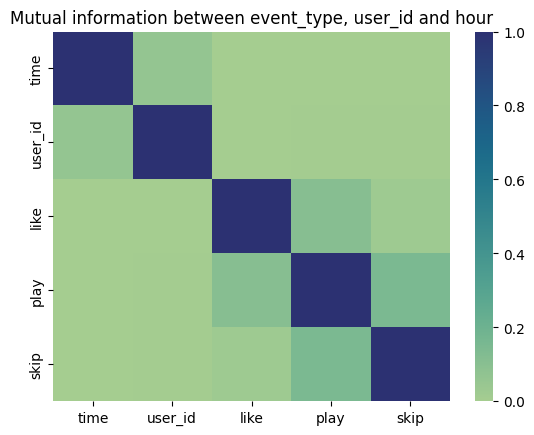

             time   user_id      like      play      skip
time     1.000000  0.059511  0.000000  0.001550  0.000000
user_id  0.059511  1.000000  0.000626  0.004531  0.004154
like     0.000000  0.000626  1.000000  0.107782  0.026232
play     0.001550  0.004531  0.107782  1.000000  0.149192
skip     0.000000  0.004154  0.026232  0.149192  1.000000


In [45]:
from sklearn.feature_selection import mutual_info_classif
sessions_reduced = session_data[["time", "event_type", "user_id"]].copy()
sessions_reduced["time"] = sessions_reduced["time"].dt.hour
dummy_events = pd.get_dummies(data=sessions_reduced["event_type"], drop_first=True, dtype=float)
sessions_reduced = pd.concat([sessions_reduced, dummy_events], axis=1)
sessions_reduced.drop(labels=['event_type'], axis=1, inplace=True)

sessions_mut_info = sessions_reduced.corr(method=lambda a, b: mutual_info_classif(a.reshape(-1, 1), b.reshape(-1, 1))[0])
sessions_heatmap = sns.heatmap(sessions_mut_info, cmap="crest")
sessions_heatmap.set(title="Mutual information between event_type, user_id and hour")
plt.show()
print(sessions_mut_info)

#### Zbiór track_storage
Ogólny przegląd zbioru

In [46]:
track_data = pd.read_json(DATA_PATH2, lines=True)
track_data.head()

,track_id,storage_class,daily_cost
0,0RNxWy0PC3AyH4ThH3aGK6,slow,0.010073
1,2W889aLIKxULEefrleFBFI,slow,0.009900
2,4Pnzw1nLOpDNV6MKI5ueIR,slow,0.009950
3,7GLmfKOe5BfOXk7334DoKt,slow,0.008150
4,6kD1SNGPkfX9LwaGd1FG92,slow,0.009309


In [47]:
track_data.describe(include="all")

,track_id,storage_class,daily_cost
count,22412,22412,22412.000000
unique,22412,3,NaN
top,0RNxWy0PC3AyH4ThH3aGK6,slow,NaN
freq,1,19044,NaN
mean,NaN,NaN,0.013217
std,NaN,NaN,0.005989
min,NaN,NaN,0.001531
25%,NaN,NaN,0.009913
50%,NaN,NaN,0.011666
75%,NaN,NaN,0.014652


#### Procent wartości null w zbiorze track_storage

In [48]:
track_data.isnull().sum() / 100 * len(track_data)

track_id         0.0
storage_class    0.0
daily_cost       0.0
dtype: float64

#### Atrybuty w zbiorze track_storage:
* track_id - id utworu, string, sekwencja
* storage_class - cache, w którym przechowywany jest utwór, string, atrybut dyskretny porządkowy, wartości - [slow, medium, fast]
* daily_cost - dzienny koszt przechowywania utworu na w danym poziomie cache'u, float, atrybut ciągły 

#### Atrybut storage_class

Rozkład:

In [49]:
track_data["storage_class"].value_counts()

storage_class
slow      19044
medium     3346
fast         22
Name: count, dtype: int64

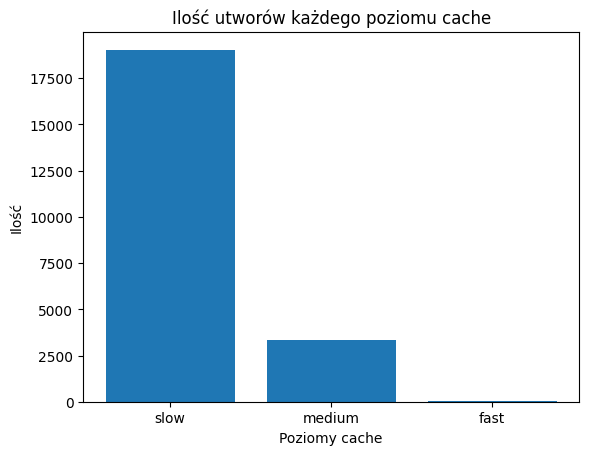

In [50]:
plt.title("Ilość utworów każdego poziomu cache")
plt.xlabel("Poziomy cache")
plt.ylabel("Ilość")
plt.bar(track_data["storage_class"].unique(), track_data["storage_class"].value_counts(), align='center')
plt.show()

#### Atrybut daily_cost

Średnia wartość atrybutu:

In [51]:
track_data["daily_cost"].mean()

0.013217481893628124

Rozkład:

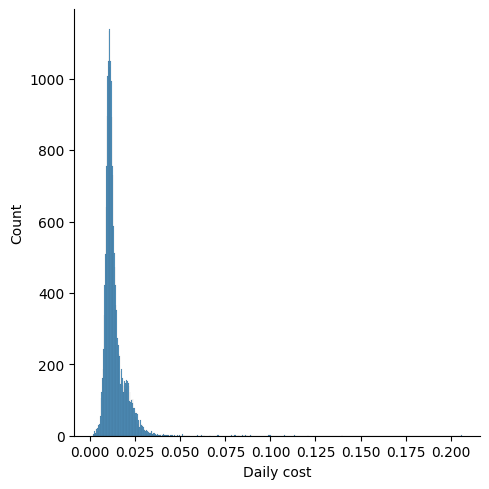

In [52]:
cost_hist = sns.displot(track_data, x="daily_cost")
cost_hist.set(xlabel="Daily cost")
plt.show()

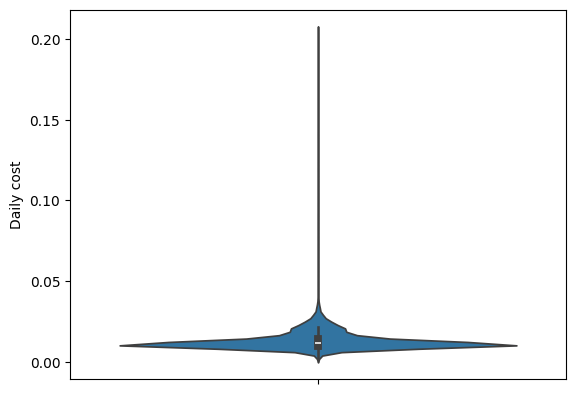

In [53]:
cost_violin = sns.violinplot(track_data["daily_cost"])
cost_violin.set(ylabel= "Daily cost")
plt.show()

#### Macierz korelacji
Do obliczenia wykorzystaliśmy metodę Spearmana - można jej używać przy atrybutach porządkowych. Obliczyliśmy korelację między atrybutami daily_cost i storage_class - nie ma sensu liczyć korelacji z atrybutem track_id.

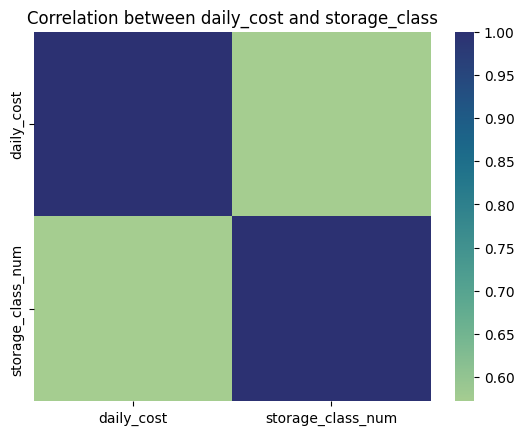

                   daily_cost  storage_class_num
daily_cost           1.000000           0.572276
storage_class_num    0.572276           1.000000


In [54]:
track_data["storage_class_num"], uniques = pd.factorize(track_data["storage_class"])
track_corr_matrix = track_data[track_data.columns[2:]].corr(method="spearman")
track_corr_heatmap = sns.heatmap(track_corr_matrix, cmap="crest")
track_corr_heatmap.set(title="Correlation between daily_cost and storage_class")
plt.show()
print(track_corr_matrix)

#### Zbiór tracks
Ogólny przegląd zbioru

In [55]:
tracks = pd.DataFrame(pd.read_json(DATA_PATH3, lines=True))
tracks.head()

,id,name,popularity,duration_ms,explicit,id_artist,release_date,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0RNxWy0PC3AyH4ThH3aGK6,Mack the Knife,55,201467,0,19eLuQmk9aCobbVDHc6eek,1929,0.673,0.3770,0,-14.141,0.0697,0.586,0.000000,0.332,0.713,88.973
1,2W889aLIKxULEefrleFBFI,Someone to Watch Over Me,54,198000,0,1Mxqyy3pSjf8kZZL4QVxS0,1943,0.204,0.1510,2,-17.842,0.0418,0.947,0.000009,0.321,0.134,91.783
2,4Pnzw1nLOpDNV6MKI5ueIR,Nancy (With the Laughing Face) - 78rpm Version,55,199000,0,1Mxqyy3pSjf8kZZL4QVxS0,1944,0.295,0.0826,1,-19.569,0.0367,0.984,0.000358,0.156,0.169,128.600
3,7GLmfKOe5BfOXk7334DoKt,Saturday Night (Is The Loneliest Night In The ...,54,163000,0,1Mxqyy3pSjf8kZZL4QVxS0,1944,0.561,0.3350,9,-11.093,0.0499,0.840,0.000002,0.788,0.590,126.974
4,6kD1SNGPkfX9LwaGd1FG92,Put Your Dreams Away (For Another Day),53,186173,0,1Mxqyy3pSjf8kZZL4QVxS0,1944,0.197,0.0546,1,-22.411,0.0346,0.950,0.276000,0.152,0.100,90.150


In [56]:
tracks.describe(include="all")

,id,name,popularity,duration_ms,explicit,id_artist,release_date,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,22412,22412,22412.000000,2.241200e+04,22412.000000,22412,22412,22412.000000,22412.000000,22412.000000,22412.000000,22412.000000,22412.000000,22412.000000,22412.000000,22412.000000,22412.000000
unique,22412,17727,NaN,NaN,NaN,1418,3907,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,0RNxWy0PC3AyH4ThH3aGK6,Home,NaN,NaN,NaN,06HL4z0CvFAxyc27GXpf02,2013-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,11,NaN,NaN,NaN,306,268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,61.375602,2.301383e+05,0.166607,NaN,NaN,0.599096,0.648017,5.278824,-7.196227,0.082914,0.267758,0.040220,0.193141,0.518000,121.911945
std,NaN,NaN,8.048246,7.209562e+04,0.372633,NaN,NaN,0.158259,0.209577,3.558813,3.738098,0.089317,0.276111,0.152828,0.167943,0.244477,29.615254
min,NaN,NaN,51.000000,3.062200e+04,0.000000,NaN,NaN,0.000000,0.000103,0.000000,-44.410000,0.000000,0.000001,0.000000,0.012000,0.000000,0.000000
25%,NaN,NaN,55.000000,1.914930e+05,0.000000,NaN,NaN,0.495000,0.508000,2.000000,-8.614500,0.033900,0.029800,0.000000,0.094400,0.325000,97.988000
50%,NaN,NaN,60.000000,2.206670e+05,0.000000,NaN,NaN,0.608000,0.672000,5.000000,-6.393000,0.046300,0.165000,0.000003,0.125000,0.512000,120.041000
75%,NaN,NaN,67.000000,2.562400e+05,0.000000,NaN,NaN,0.715000,0.816000,8.000000,-4.850000,0.086000,0.455000,0.000523,0.240000,0.713000,140.078000


#### Procent wartości null w zbiorze track_storage

In [57]:
tracks.isnull().sum() / 100 * len(track_data)

id                  0.0
name                0.0
popularity          0.0
duration_ms         0.0
explicit            0.0
id_artist           0.0
release_date        0.0
danceability        0.0
energy              0.0
key                 0.0
loudness            0.0
speechiness         0.0
acousticness        0.0
instrumentalness    0.0
liveness            0.0
valence             0.0
tempo               0.0
dtype: float64

W zbiorze tracks nie ma nulli

#### Atrybut duration_ms

Średnia wartość atrybutu

In [58]:
tracks["duration_ms"].mean()

230138.3092539711

Rozkład:

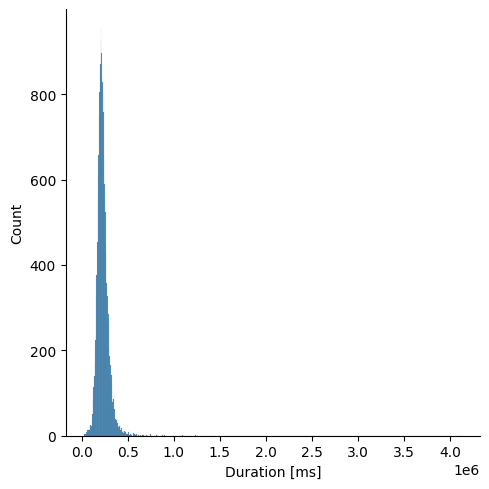

In [59]:
duration_hist = sns.displot(tracks, x="duration_ms")
duration_hist.set(xlabel="Duration [ms]")
plt.show()

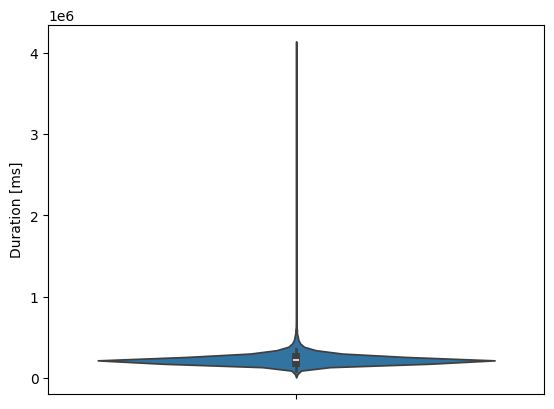

In [60]:
duration_hist = sns.violinplot(tracks["duration_ms"])
duration_hist.set(ylabel= "Duration [ms]")
plt.show()

#### Ocena danych
##### Tabela track_storage
W tabeli track_storage znajduje się 22412 rekordów. Tabela reprezentuje obecne stałe koszty dla poszczególnych utworów. Nie zawiera ona żadnych nulli. Wartości atrybutu daily_cost mogą posłużyć do oceny modelu - czy uzyskane koszta będą sumarycznie lepsze od wartości w tej tabeli. Atrybut storage_class jest mocno niezbalansowany - zawiera 19044 wartości slow, 3346 wartości medium i 22 wartości fast. Dysproporcja ta wynika prawdopodobnie
z różnych rozmiarów poziomów cache'u - najszybszy cache jest najmniejszy, a najwolniejszy jest największy. Niemniej jednak ilości występowania poszczególnych wartości dla atrybutu storage_class są bardzo duże - zwłaszcza dla wartości „fast”. Być może należy zastosować metody oversamplingu/undersamplingu do zmniejszenia tej dysproporcji, ewentualnie zignorować ten atrybut.

##### Tabela sessions
W tabeli sessions jest 80279 rekordów. Tabela reprezentuje sesje użytkowników. Tabela zawiera sporo wartości null w atrybutach event_type, user_id i track_id. Planujemy je obsłużyć - np. dla wartości event_type = advertisment wartość track_id jest zawsze równa null - można zastąpić wartości null dodatkową wartością. Oprócz tego jeśli event_type = skip lub event_type = like i wartość track_id nie jest nullem a dla poprzedniego rekordu o tym samym id sesji i użytkownika brakuje wartości track_id, można wstawić tam wartość track_id następnego rekordu. Jeśli dla kilku rekordów z tym samym session_id brakuje wartości user_id to można je uzupełnić wartościami id użytkownika z rekordów tej sesji. Oprócz tego występują też braki których nie możemy tak łatwo obsłużyć - np. braki wartości w 2 lub więcej kolumnach. Wtedy należało by rozważyć usunięcie wybrakowanych rekordów - jeśli nie będzie ich zbyt wiele, lub uzupełnić dane. 

#### Tabela tracks
W tabeli tracks znajduje się 22412 rekordów - tyle samo co w tabeli track_storage, więc można uznać, że dla każdego utworu przypisany jest poziom cache. Tabela nie zawiera żadnych nulli - dla każdego utworu przypisany jest czas. 

#### Potrzebne zbiory i atrybuty
1. Tabela sessions
    - "session_id" - do obliczenia średniego czasu dostępu do utworu
    - "timestamp" - do obliczenia średniego czasu dostępu do utworu i jako atrybut wejściowy modelu
    - "event_type" i "track_id" - tak samo jak timestamp
2. Tabela track_storage
    - "storage_type" i "track_id" -  do policzenia bazowego kosztu w kryterium sukcesu
3. Tabela tracks
    - "duration_ms" - do obliczenia średniego czasu dostępu do muzyki i kosztu umieszczenia utworu w określonym cache'u w kryterium sukcesu 
Tabele artists i users nie wydają się potrzebne do realizacji zadania.

#### Dane wejściowe i zmienna celu
Danymi wejściowymi modelu będą atrybuty:
1. "timestamp" - popularność danego utworu jest umieszczona w czasie; ewentualnie czas, który upłynął od momentu odtworzenia danego utowru
2. "track_id" - musimy wiedzieć, który utwór jest popularny i często odtwarzany
3. "event_type" - typ wydarzenia, jeśli utwór ma dużo wydarzeń typu "skip" to prawdopodobnie nie spodobał się użytkownikowi, a jeśli ma dużo 
wydarzeń typu "play" i "like" to prawdopodobnie jest warty wzięcia pod uwagę w modelowaniu jako potencjalnie popularny utwór.
Dane z tabeli track_storage.jsonl zawierają obecnie określone przypisania utworów do odpowiednich cache'y - możemy to wykorzystać do obliczenia kosztów bazowych. W tej chwili widzimy, że około 5,7 razy więcej jest przypisanych utworów do cache'a "slow" niż do "medium" zaś do "medium" było przypisane około 152 razy więcej utworów niż do "fast". Są to odpowiednio jeden oraz dwa rzędy wielkości pomiędzy wyszczególnionymi poziomami. Analogiczną proporcję można wykorzystać do liczenia funkcji celu. 
Po uzyskaniu pozostałych zbiorów danych należy przeanalizować je i zobaczyć, czy znajdują się tam informacje, które mogą wpłynąć pozytywnie na ostatecznie utrzymany model.
